# Welcome to Google Colab

Colab is essentially Google's way of hosting a [jupyter notebook](https://jupyter.org/). A very popular tool to use as a data scientist!

It allows us to write code, documentation, and output visuals all in one place.

To edit the code in this workshop. Please make a copy for yourself

`file > save a copy in drive`

This should open a new tab with your own copy of this notebook. It can take a minute to load.

This is a text cell. 

You can add a new text cell by clicking `+ Text` above.

# Intro To Time Series
[by Galvanize data science](https://glv.nz/2YCjak9)

## Load Avocado Data
Pandas is a powerful and easy to use open source data analysis library built on top of the Python programming language.
https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf  
*shift + enter will run the code cell and advance cell selection*

In [6]:
import pandas as pd

`pd.read_csv()` is able to create a dataframe from a link or csv file on your local machine.
The linked .csv is a small subset of time series data from this Kaggle avocado data source. https://www.kaggle.com/neuromusic/avocado-prices/

In [7]:
df_avocado = pd.read_csv('https://raw.githubusercontent.com/dataScienceCurriculum/intro_time_series/main/avocado_dal.csv', sep=',')
# Change the data type in the 'Date' column to datetime
df_avocado['Date'] = pd.to_datetime(df_avocado['Date'])

We can use the `.head()` method to view the first 5 rows. The interval between dates is weekly.  
Thankfully, there are no missing values in our data.

In [8]:
print('rows by columns', df_avocado.shape)
df_avocado.head()

rows by columns (169, 8)


,Week,Date,year,region,AveragePrice Conventional,Total Volume Conventional,AveragePrice Organic,Total Volume Organic
0,51,2015-01-04,2015,DallasFtWorth,0.74,1086363.97,1.35,9895.96
1,50,2015-01-11,2015,DallasFtWorth,0.76,1128693.04,1.35,12126.63
2,49,2015-01-18,2015,DallasFtWorth,0.76,1091677.29,1.28,12634.71
3,48,2015-01-25,2015,DallasFtWorth,0.80,1008295.47,1.34,11247.71
4,47,2015-02-01,2015,DallasFtWorth,0.68,1391089.32,1.24,12276.58


## Asking some basic questions
This .csv data file only contains data for the DallasFtWorth region. Please see the Kaggle page for the complete dataset.   
**From what date range do we have avocado price data?**

In [9]:
start_date = df_avocado['Date'].min()
end_date = df_avocado['Date'].max()
print('beginning of data', start_date)
print('end of data', end_date)

beginning of data 2015-01-04 00:00:00
end of data 2018-03-25 00:00:00


**What are the average prices of conventional and organic avocados?**

In [10]:
mean_conventional = round(df_avocado['AveragePrice Conventional'].mean(), 2)
mean_organic = round(df_avocado['AveragePrice Organic'].mean(), 2)
print('Conventional avocado average price', mean_conventional)
print('Organic avocado average price', mean_organic)

Conventional avocado average price 0.85
Organic avocado average price 1.32


**What are the average volumes of conventional and organic avocados?**

In [11]:
vol_conventional = round(df_avocado['Total Volume Conventional'].mean(), 2)
vol_organic = round(df_avocado['Total Volume Organic'].mean(), 2)
print('Conventional avocado average volume', vol_conventional)
print('Organic avocado average volume', vol_organic)

Conventional avocado average volume 1212484.8
Organic avocado average volume 20765.42


# Let's Get Plotting

In [12]:
import matplotlib.pyplot as plt
# use inline to ensure the plot shows
%matplotlib inline



---


Before plotting a time series. Let's check out price distributions with a histogram plot.

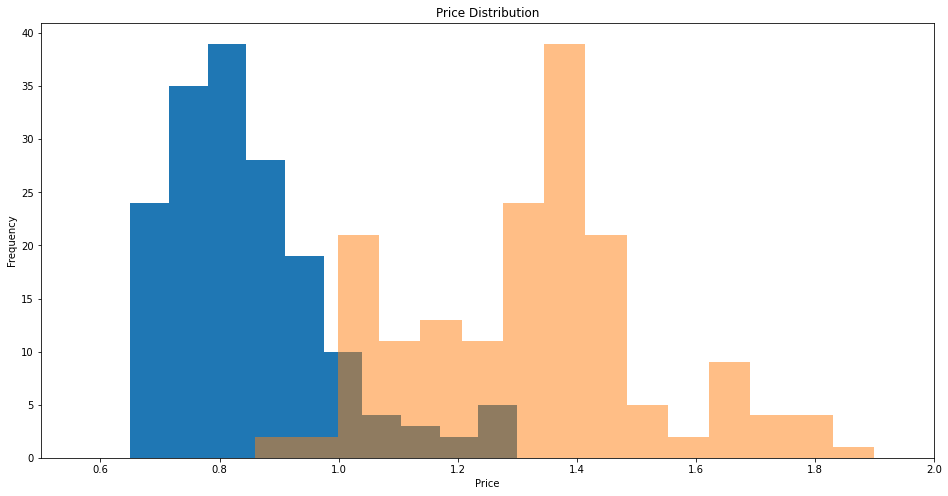

In [13]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('Price Distribution')
ax.set_xlabel('Price')
df_avocado['AveragePrice Conventional'].plot(kind='hist', ax=ax, bins = 10, xlim = (0.5,2.0))
df_avocado['AveragePrice Organic'].plot(kind='hist', ax=ax, bins = 15, xlim = (0.5,2.0), alpha=0.5)



---


Avocado weekly average price time series

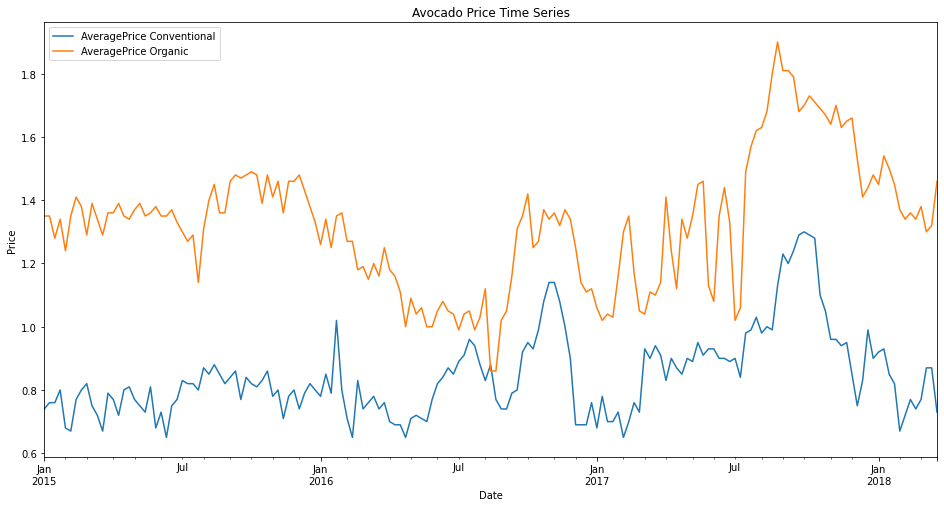

In [14]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('Avocado Price Time Series')
ax.set_ylabel('Price')
df_avocado.plot(kind='line', ax=ax, x='Date', y='AveragePrice Conventional')
df_avocado.plot(kind='line', ax=ax, x='Date', y='AveragePrice Organic')



---

Conventional avocado weekly volume time series

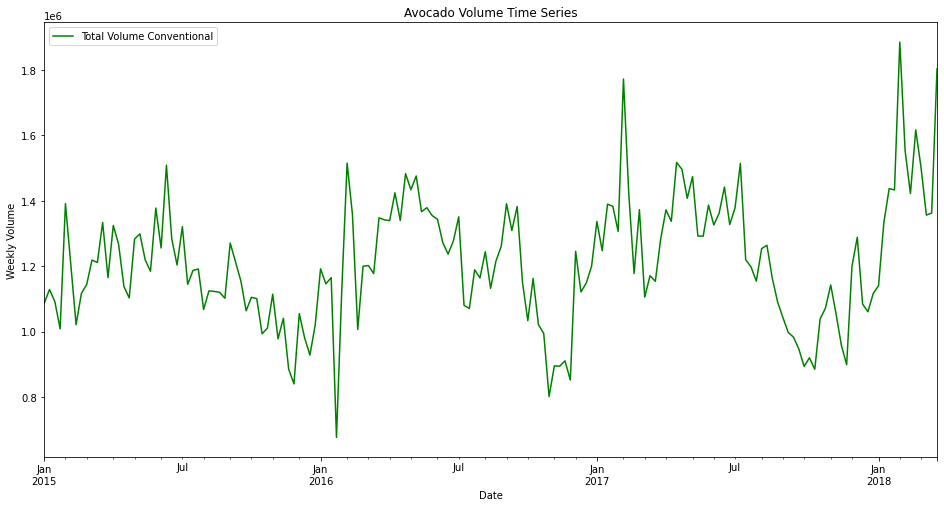

In [15]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('Avocado Volume Time Series')
ax.set_ylabel('Weekly Volume')
df_avocado.plot(kind='line', ax=ax, x='Date', y='Total Volume Conventional', c='g')

# Moving Average

Let's calculate values for different moving averages so we can plot them

In [17]:
df_avocado['24 week MA'] = df_avocado['AveragePrice Conventional'].rolling(window=24).mean()
df_avocado['12 week MA'] = df_avocado['AveragePrice Conventional'].rolling(window=12).mean()

Now the calculated moving average is saved to new columns in the dataframe.

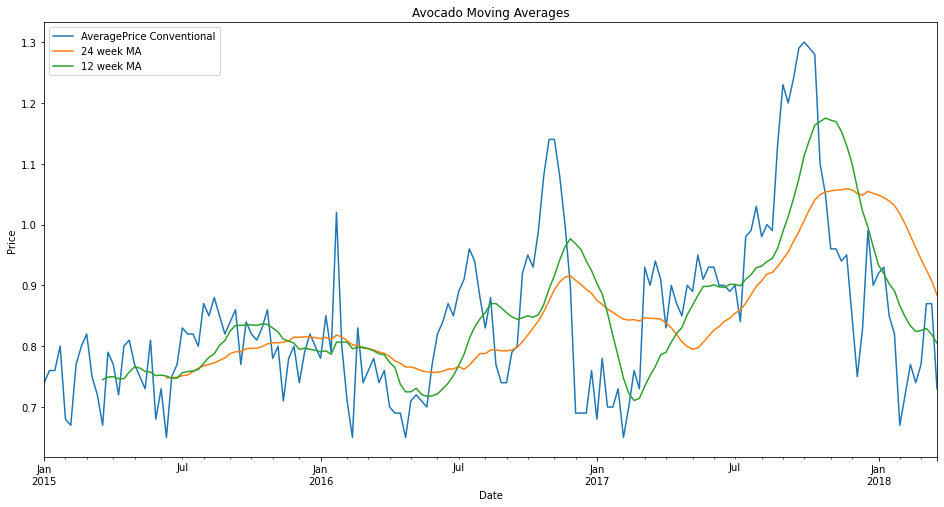

In [18]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('Avocado Moving Averages')
ax.set_ylabel('Price')
df_avocado.plot(kind='line', ax=ax, x='Date', y='AveragePrice Conventional')
df_avocado.plot(kind='line', ax=ax, x='Date', y='24 week MA')
df_avocado.plot(kind='line', ax=ax, x='Date', y='12 week MA')



---

The moving average is great for investigating past data. But what about the future?

# Forecast

A linear forecast would be a very basic forecast attempt. We can do better.
[Kaggle notebook reference](https://www.kaggle.com/ilyapozdnyakov/avocado-price-prediction-xgb-pca-prophet)
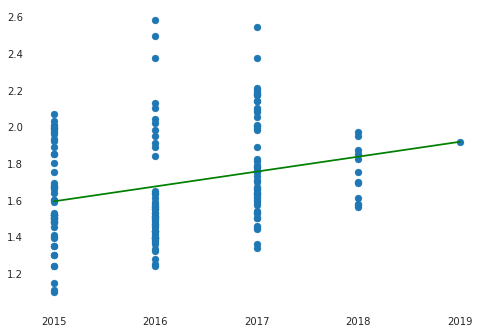

## Prophet
https://facebook.github.io/prophet/  
Prophet is a univariate forecast model with seasonality. Roughly explained, it solves for curves that fit different seasonalities in the data.

In [19]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

## Data Prep
Prophet wants the data in a specific dataframe format with specific names. So we need to prepare the data for it.  
`'ds'` must be column name for time data  
`'y'` must be column name for time series variable

In [20]:
df_ts = pd.DataFrame() 
df_ts['ds'] = df_avocado['Date']
df_ts['y'] = df_avocado['AveragePrice Conventional']
df_ts.tail()

,ds,y
164,2018-02-25,0.74
165,2018-03-04,0.77
166,2018-03-11,0.87
167,2018-03-18,0.87
168,2018-03-25,0.73


## Create The Model  
Instantiate an empty model. Then, give it our time series data.

In [21]:
model = Prophet()
model.fit(df_ts)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




---


`model.make_future_dataframe()` This is use to define the forecast you want to make.



In [22]:
df_future = model.make_future_dataframe(periods=52, freq='W')
df_future.tail()

,ds
216,2019-02-24
217,2019-03-03
218,2019-03-10
219,2019-03-17
220,2019-03-24




---


Inspect `df_forecast.columns` to investigate what the model gave us. Check Prophet documentation for output definitions.

In [23]:
df_forecast = model.predict(df_future)
print(df_forecast.columns)
df_forecast[['ds', 'yhat']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat
216,2019-02-24,0.948943
217,2019-03-03,0.989145
218,2019-03-10,1.001241
219,2019-03-17,0.989775
220,2019-03-24,0.977659


## Forecast Plotting
Prophet has a useful plotting method to show the forecast data.  
The forecast truly starts when the black data points end.

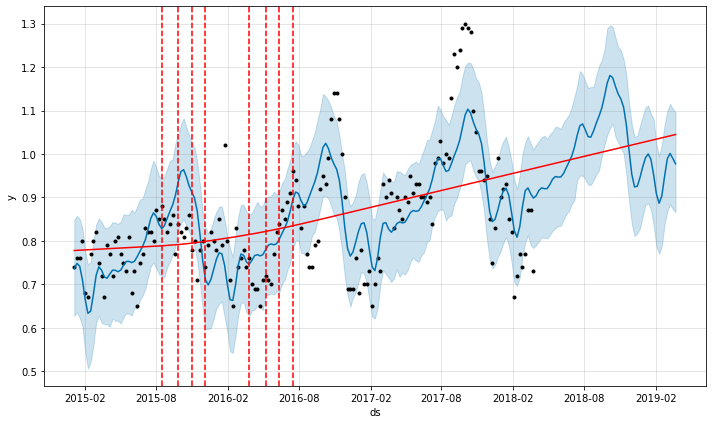

In [24]:
figure = model.plot(df_forecast)
a = add_changepoints_to_plot(figure.gca(), model, df_forecast)

In Prophet, the default confidence interval is set at 80%  
**Do 80% of the black dot datapoints fall within the blue shaded area?**  


---


### Plotting components that combine together to make the forecast

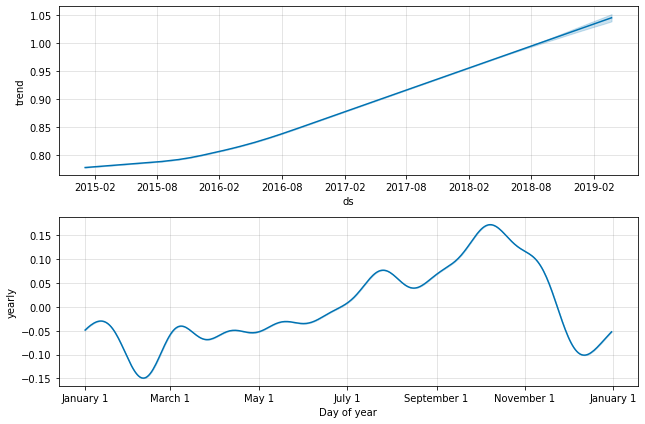

In [25]:
figure_components = model.plot_components(df_forecast)



---


### Now put everything you made in one plot!

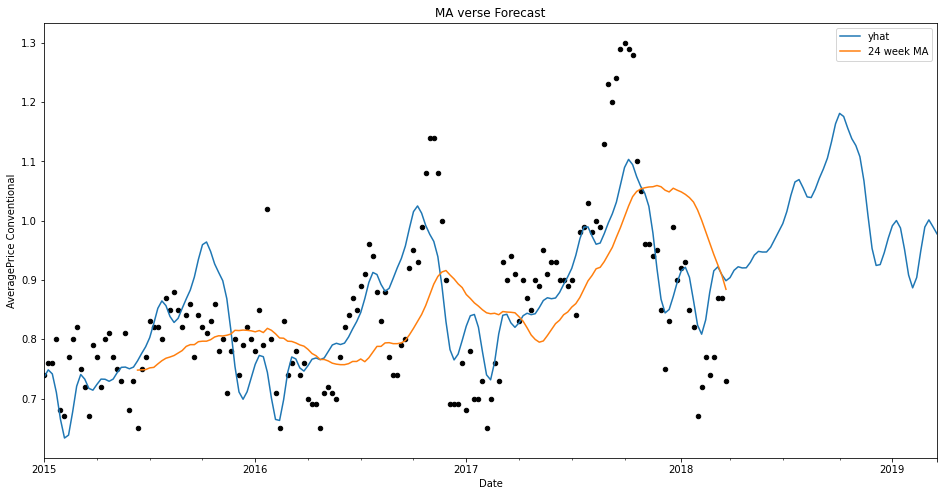

In [26]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('MA verse Forecast')
ax.set_ylabel('Price')
df_forecast.plot(kind='line', ax=ax, x='ds', y='yhat')
df_avocado.plot(kind='line', ax=ax, x='Date', y='24 week MA')
df_avocado.plot(kind='scatter', ax=ax, x='Date', y='AveragePrice Conventional', c='k')



---


# More Things To Try
1. Make a forecast on the avocado weekly volume time series. Is avocado 
consumption growing?
2. Make a forecast for organic avocados.
3. Use the full Kaggle dataset and make forecasts for different regions in the data. Where is avocado volume growing?  
https://www.kaggle.com/neuromusic/avocado-prices/  
4. Look for our 'Intro To Pandas' workshop.
## Additional links  

[Free Galvanize Data Science Prep Course](https://glv.nz/2YCjak9)

[More time series notebooks on Kaggle](https://www.kaggle.com/search?q=time+series+in%3Anotebooks)

